# ARMA, ARIMA, SARIMA

## Overview

In the previous four lessons, we learned about stationarity, smoothing, trend, seasonality, and autocorrelation, and you built two different kinds of models: 

- **MA models**: The current value of the series depends linearly on the series' mean and a set of prior (observed) white noise error terms.

- **AR models**: The current value of the  series depends linearly on its own previous values and on a stochastic term (an imperfectly predictable term).
  
In this lesson we will review these concepts and combine the AR and MA models into three more complicated ones: ARMA, ARIMA, and SARIMA.

In particular, we will cover:

1. Autoregressive Moving Average (ARMA) models.
2. Autoregressive Integrated Moving Average (ARIMA) models.
3. SARIMA models (ARIMA model for data with seasonality).
4. Selecting the best model.

In [206]:
import sys
if 'google.colab' in sys.modules:
    !pip install -U -qq tsa-course pmdarima

In [207]:
# Imports
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', ValueWarning)
warnings.simplefilter('ignore', UserWarning)
import time
# from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels as ss
import statsmodels.api as sm
import seaborn as sns
from tqdm.notebook import tqdm
from scipy import stats
from scipy.fft import fft
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import ccf, adfuller
from statsmodels.graphics.tsaplots import month_plot, plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import mse
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.arima_process import arma_generate_sample
# %pip install pmdarima
import pmdarima as pm
# from tsa_course.lecture1 import fft_analysis
np.random.seed(0)                

---

## ARMA

The ARMA model (also known as the *Box-Jenkins* approach) combines two models:

- An autoregressive (AR) model of order $p$.
- A moving average (MA) model of order $q$.

- When we have autocorrelation between outcomes and their ancestors, there will be a pattern in the time series. 
- This relationship can be modeled using an ARMA model. 
- It allows us to predict the future with a confidence level proportional to the strength of the relationship and the proximity to known values.

**📝 Note**

- ARMA models assume the time series is assumed to be stationary.
- A good rule of thumb is to have at least 100 observations when fitting an ARMA model.

### Load data

- In the following, we'll look at the monthly average temperatures between 1907-1972.

In [208]:
# load data and convert to datetime
monthly_temp = pd.read_csv('https://zenodo.org/records/10951538/files/arima_temp.csv?download=1', 
                           skipfooter=2, header=0, index_col=0, names=['month', 'temp'], engine='python')
monthly_temp.index = pd.to_datetime(monthly_temp.index)

- This is how the data looks like.

In [209]:
monthly_temp.head()

,temp
month,
1907-01-01,33.3
1907-02-01,46.0
1907-03-01,43.0
1907-04-01,55.0
1907-05-01,51.8


- These are some statistics.

In [210]:
monthly_temp.describe()
792/12

66.0

- This is the run sequence plot.

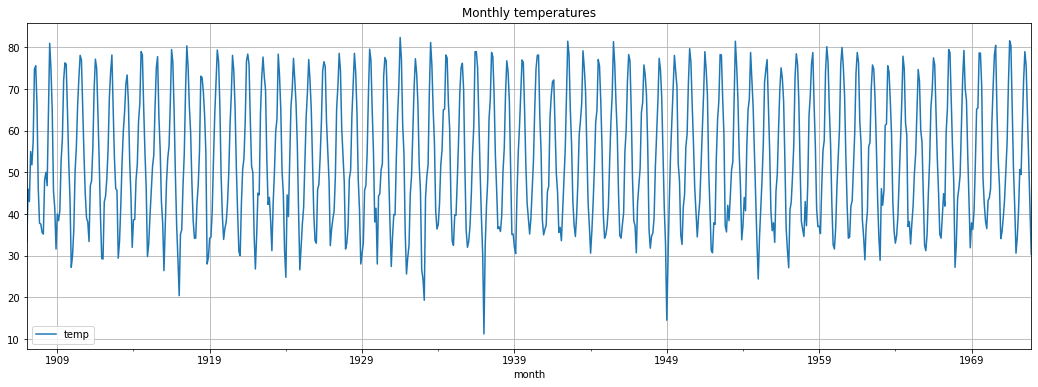

In [211]:
monthly_temp.plot(grid=True, figsize=(18,6), title='Monthly temperatures');

- Compute the annual mean and plot it on top of the actual data.

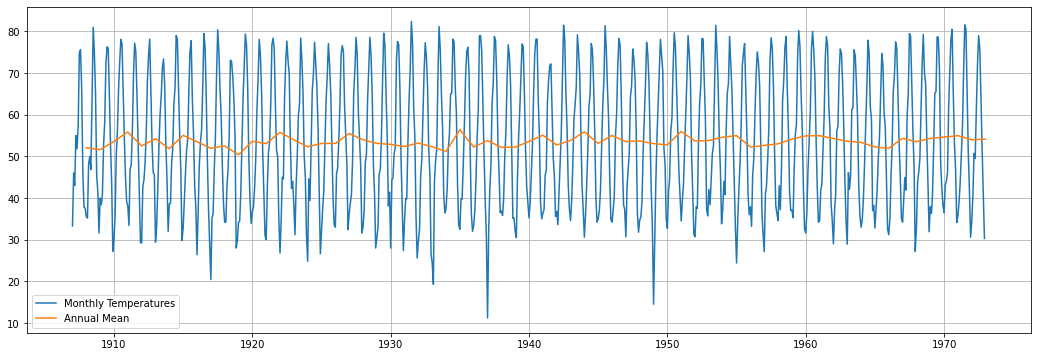

In [212]:
# Compute annual mean 
annual_temp = monthly_temp.resample('YE').mean() # annual_temp = monthly_temp.rolling(12).mean()
annual_temp.index.name = 'year'

plt.figure(figsize=(18,6))
plt.plot(monthly_temp, label="Monthly Temperatures")
plt.plot(annual_temp, label="Annual Mean")
plt.grid(); plt.legend();

- This gives us an indication that the mean is rather constant over the years.
- We can extract further information abouth the underlying trend and seasonality by performing a seasonal decomposition.
- We can use both the `seasonal_decompose` and the `STL` methods.

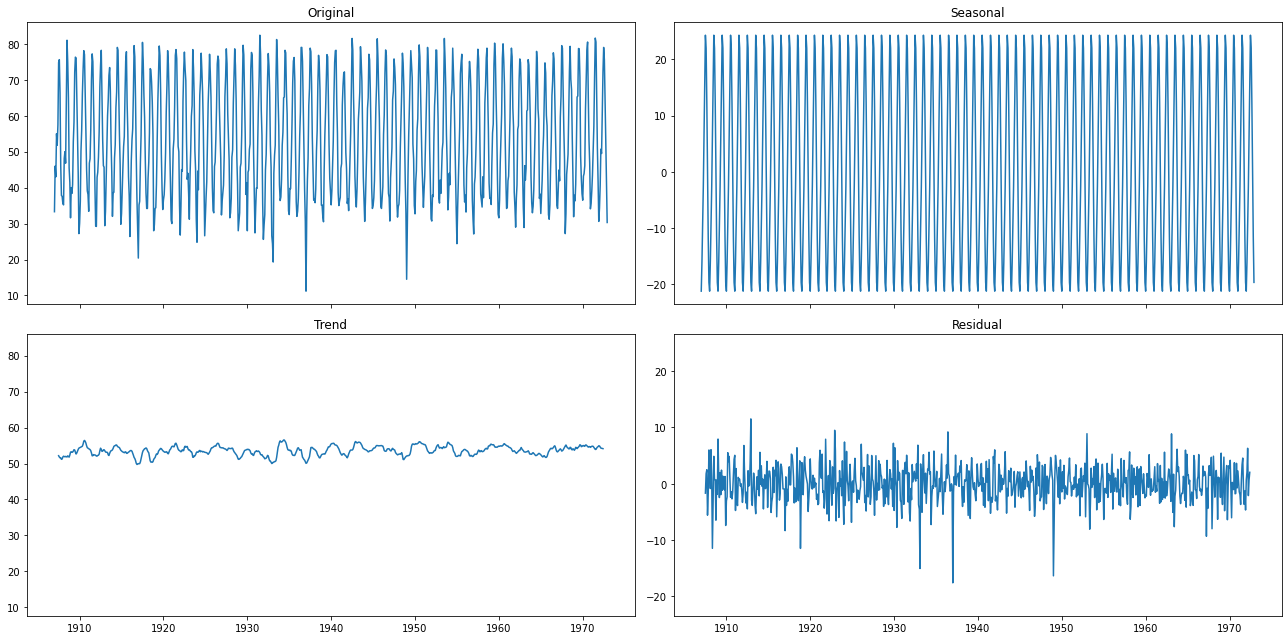

In [213]:
decomposition = seasonal_decompose(x=monthly_temp['temp'], model='additive', period=12)
seasonal, trend, resid = decomposition.seasonal, decomposition.trend, decomposition.resid

fig, axs = plt.subplots(2,2, sharex=True, figsize=(18,9))
axs[0,0].plot(monthly_temp['temp']); axs[0,0].set_title('Original')
axs[0,1].plot(seasonal); axs[0,1].set_title('Seasonal')#; axs[0,1].set_ylim(axs[0,0].get_ylim())
axs[1,0].plot(trend); axs[1,0].set_title('Trend'); axs[1,0].set_ylim(axs[0,0].get_ylim())
axs[1,1].plot(resid); axs[1,1].set_title('Residual'); axs[1,1].set_ylim(axs[0,1].get_ylim())
plt.tight_layout()

- The seasonality is well defined.
- Trend doesn't seem to be a strong and time-varying.
    - We can assume the trend is constant (for stationarity).
    
---

## ARMA modeling stages

There are three stages in building an ARMA model:

1. Model identification.
2. Model estimation.
3. Model evaluation.

### Model identification

- Model identification consists in finding the orders $p$ and $q$ AR and MA components.
- Before performing model identification we need to:
    1. Determine if the time series is stationary.
    2. Determine if the time series has seasonal component.

#### Determine stationarity

- We can use tools we already know (such as ADF test).
- We can also look at the rolling mean and rolling std.

<br>
<div style="text-align: center; font-size: 30px; font-weight: bold;">⚠ Attention! ⚠</div>
<br>

- Before we continue, let's consider the following result

In [214]:
sinusoid = np.sin(np.arange(200))
testval, pval, _, _, _, _ = adfuller(sinusoid)
print(testval, pval)

-1.3451537116176384e+16 0.0


<!-- - Periodic signals, by their nature, have means and variances that repeat over the period of the cycle. 
- This implies that their statistical properties are functions of time within each period. 
- For instance, the mean of a periodic signal over one cycle may be constant.
- However, when considering any point in time relative to the cycle, the instantaneous mean of the signal can vary. 
- Similarly, the variance can fluctuate within the cycle. -->

- The ADF test specifically looks for shocks to the time series that have a permanent effect (causing drifts in the level of the series). 
- A sinusoidal function, by contrast, is inherently *mean-reverting* within its cycles.
- After a peak a sinusoid reverts to its mean and fluctuations are not persisting.

- It's crucial to note that the ADF test's conclusion of stationarity for a sinusoid does not imply that the sinusoid is stationary. 
- The test's conclusion is about the absence of permanent shocks.
- Obviously the mean and variance are not constant **within periodic cycles**.

---

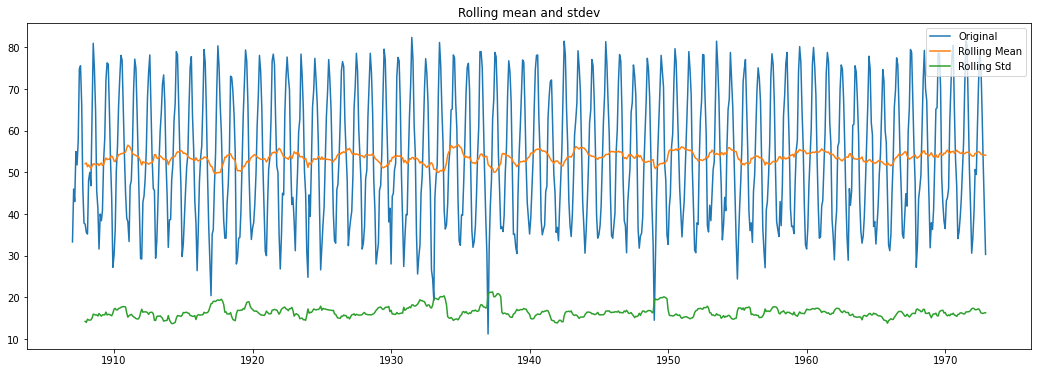

In [215]:
plt.figure(figsize=(18, 6))
plt.plot(monthly_temp.temp, label='Original')
plt.plot(monthly_temp.temp.rolling(window=12).mean(), label='Rolling Mean')
plt.plot(monthly_temp.temp.rolling(window=12).std(), label = 'Rolling Std')
plt.title('Rolling mean and stdev')
plt.legend()

- The rolling mean and rolling standard deviation seem globally constant along the time series...
- ... even if they change locally within the period.

#### Determine seasonality

We can determine if seasonality is present by using the following tools:
- Autocorrelation plot.
- Seasonal subseries plot (month plot).

In [216]:
monthly_temp

,temp
month,
1907-01-01,33.3
1907-02-01,46.0
1907-03-01,43.0
1907-04-01,55.0
1907-05-01,51.8
...,...
1972-08-01,75.6
1972-09-01,64.1
1972-10-01,51.7


In [217]:
monthly_temp

,temp
month,
1907-01-01,33.3
1907-02-01,46.0
1907-03-01,43.0
1907-04-01,55.0
1907-05-01,51.8
...,...
1972-08-01,75.6
1972-09-01,64.1
1972-10-01,51.7


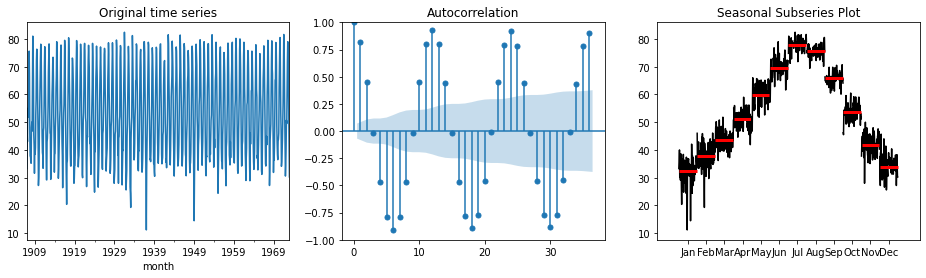

In [218]:
fig, axes = plt.subplots(1,3,figsize=(16,4))
monthly_temp['temp'].plot(ax=axes[0], title="Original time series")

# ACF Plot
plot_acf(monthly_temp['temp'], lags=36, ax=axes[1]);
monthly_temp['month'] = monthly_temp.index.month
# Seasonal Subseries Plot
month_plot(monthly_temp['temp'], ax=axes[2]); axes[2].set_title("Seasonal Subseries Plot");

- Let's look closer at `month_plot`

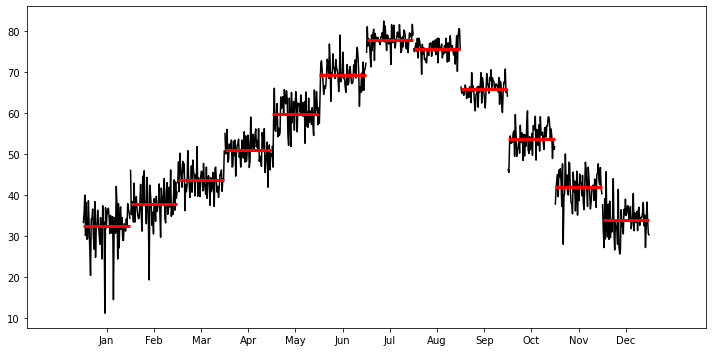

In [219]:
fig, ax= plt.subplots(1,1,figsize=(10,5))
month_plot(monthly_temp['temp'], ax=ax)
plt.tight_layout();

- Notice that a `violinplot` can give a very similar information to the `month_plot`.

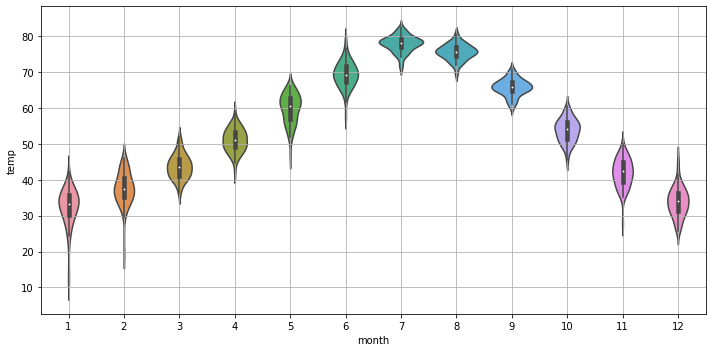

In [220]:
fig, ax= plt.subplots(1,1,figsize=(10,5))
sns.violinplot(x=monthly_temp.index.month, y=monthly_temp.temp, ax=ax) # notice the indexing on the x by month
plt.tight_layout()
plt.grid();

#### Remove the main seasonality

- In this case, it is clear that the main seasonality is $L=12$.
- We can remove it with a seasonal differencing.

In [221]:
monthly_temp['seas_diff'] = monthly_temp['temp'].diff(12)
monthly_temp = monthly_temp.dropna()
# note the difference between np.diff() and df.diff()

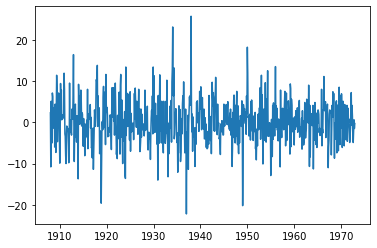

In [222]:
plt.plot(monthly_temp['seas_diff'])

**⚙ Try it yourself**

- Try redoing the previous plots on the differenced data!

#### Identifying $p$ and $q$

As we learned in the previous lesson, we will identify the AR order $p$ and the MA order $q$ with:

- Autocorrelation function (ACF) plot.
- Partial autocorrelation function (PACF) plot.

**AR($p$)**

- The order of the AR model is identified as follows:
    - Plot 95% confidence interval on the PACF (done automatically by statsmodels).
    - Choose lag $p$ such that the partial autocorrelation becomes insignificant for $p+1$ and beyond.

- If a process depends on **previous values** of itself then it is an AR process. 
- If it depends on **previous errors**, then it is an MA process.
- An AR process propagates shocks infinitely.
- AR processes will exhibit exponential decay in ACF and a cut-off in PACF.

C:\Users\serhan.aydin\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


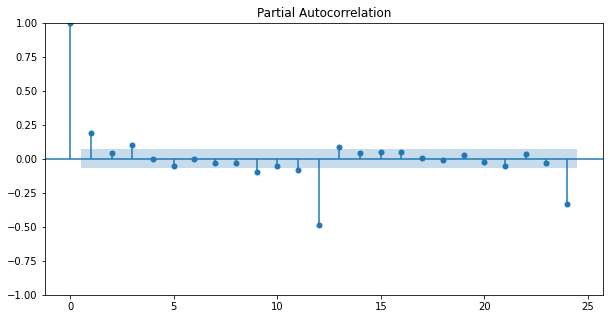

In [223]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
plot_pacf(monthly_temp['seas_diff'], lags=24, ax=ax); 

- It looks like the PACF becomes zero at lag 2.
- However there is a non-zero partial autocorrelation at lag 3.
- The optimal value might be $p=1$, $p=2$, or $p=3$.
- Note that there are high partial autocorrelations at higher lags, especially 12. 
    - This is an effect from seasonality and seasonal differencing. 
    - It should not be accounted when chosing $p$.

**MA($q$)**

- The order of the MA model is identified as follows:
    - Plot 95% confidence interval on the ACF (done automatically by statsmodels).
    - Choose lag $q$ such that ACF becomes statistically zero for $q+1$ and beyond.

- MA models do not propagate shocks infinitely; they die after $q$ lags.
- MA processes will exhibit exponential decay in PACF and a cut-off in ACF

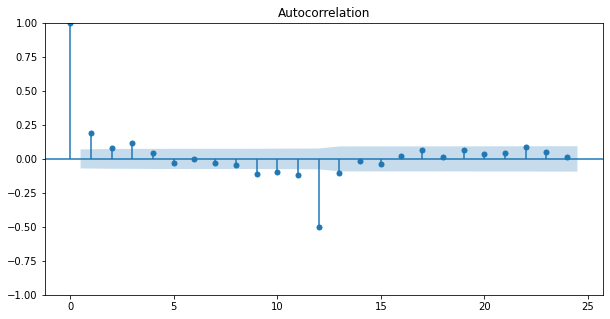

In [224]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
plot_acf(monthly_temp['seas_diff'], lags=24, ax=ax); 

- Also in this case there are non-zero autocorrelations at lags 1 and 3.
- So, the values to try are $q=1$, $q=2$, or $q=3$.

### Model estimation

- Once the orders $p$ and $q$ are identified, now estimate parameters $\phi_1, \dots, \phi_p$ of the AR part, and $\theta_1, \dots, \theta_q$ of the MA part.
- Estimating the parameters of an ARMA model is a complicated, nonlinear problem.
- Nonlinear least squares regression and maximum likelihood estimation (MLE) are common approaches.
- Many modern software programs will fit the ARMA model for us.

- We split the data in two parts:
    - the training set, that will be used to fit the model's parameters.
    - the test set, that will be used later on to evaluate the prediction performance of the model on unseen data.

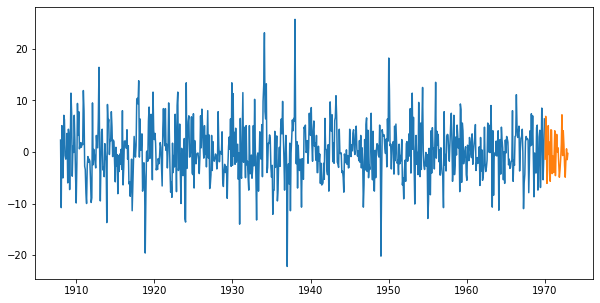

In [225]:
train = monthly_temp['seas_diff'][:-36]
test = monthly_temp['seas_diff'][-36:]

plt.figure(figsize=(10,5))
plt.plot(train)
plt.plot(test);

744

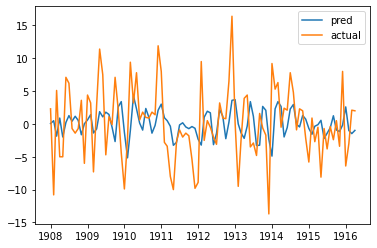

In [226]:
predict = fit_model.predict()
plt.plot(predict[:100],label='pred')
plt.plot(train[:100],label='actual')
plt.legend()
len(train)

In [227]:
%%time
for p in range(4):
    for q in range(4):
        try:
            model = ARIMA(train, order=(p,0,q))  # ARIMA with d=0 is equivalent to ARMA
            fit_model = model.fit()
            #fit_model.summary()
            predict = fit_model.predict()
        except:
            pass
        else:
            # calculate evaluation metrics: MAPE, RMSE, AIC & BIC
            # MAPE = (abs((train-predict)[1:])/(train[1:])).mean()
            MSE = mse(train[1:], predict[1:])
            AIC = fit_model.aic
            BIC = fit_model.bic
            print('ARIMA(%.0f,0,%.0f): RMSE %.2f, AIC %.2f, BIC %.2f,' % (p,q, MSE**0.5, AIC, BIC), 
                  'params:', [round(param,4) for param in fit_model.params[:-1]])

ARIMA(0,0,0): RMSE 5.30, AIC 4595.11, BIC 4604.33, params: [0.0414]
ARIMA(0,0,1): RMSE 5.20, AIC 4570.42, BIC 4584.26, params: [0.043, 0.1829]
ARIMA(0,0,2): RMSE 5.20, AIC 4571.00, BIC 4589.44, params: [0.0428, 0.1828, 0.0413]
ARIMA(0,0,3): RMSE 5.17, AIC 4564.27, BIC 4587.33, params: [0.0424, 0.1731, 0.0637, 0.1094]
ARIMA(1,0,0): RMSE 5.19, AIC 4567.93, BIC 4581.76, params: [0.044, 0.1963]
ARIMA(1,0,1): RMSE 5.18, AIC 4565.47, BIC 4583.92, params: [0.0438, 0.5842, -0.4097]
ARIMA(1,0,2): RMSE 5.18, AIC 4567.29, BIC 4590.35, params: [0.044, 0.6121, -0.4298, -0.0202]
ARIMA(1,0,3): RMSE 5.16, AIC 4564.32, BIC 4591.99, params: [0.0439, 0.34, -0.1607, 0.008, 0.0982]
ARIMA(2,0,0): RMSE 5.19, AIC 4568.26, BIC 4586.71, params: [0.0424, 0.1868, 0.0474]
ARIMA(2,0,1): RMSE 5.18, AIC 4567.35, BIC 4590.41, params: [0.0436, 0.6362, -0.0192, -0.4567]
ARIMA(2,0,2): RMSE 5.08, AIC 4541.02, BIC 4568.70, params: [0.0425, -0.2873, 0.5717, 0.5213, -0.4787]
ARIMA(2,0,3): RMSE 4.95, AIC 4502.98, BIC 4535.26,

### ARMA Model Validation

- How do you know if your ARMA model is fairly good?
- We can check the resiudals, i.e., what the model was not able to fit.
- The residuals should approximate a Gaussian distribution (aka white noise).
- Otherwise, we might need to select a better model.

In [ ]:
residuals = fit_model.resid

plt.figure(figsize=(10,5))
plt.plot(residuals)
plt.title("Residuals");

**🤔 How to test if the residuals look like noise?**

- We will use both visual inspection and statistical tests.
- Visual inspection:
    - ACF plot.
    - Histogram.
    - QQ plot.
- Statistical tests:
    - Normality.
    - Autocorrelation.
    - Heteroskedasticity.

#### Visual inspection 

**ACF plot**

- Checks for any autocorrelation in the residuals. 
- White noise should show no significant autocorrelation at all lags.

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plot_acf(residuals, lags=24, ax=ax)
plt.title('ACF of Residuals')
plt.show()

**Histogram and QQ-Plot**
- Assess the normality of the residuals. 
- White noise should ideally follow a normal distribution.

In [ ]:
# Histogram
plt.figure(figsize=(8,3))
plt.hist(residuals, bins=20, density=True, alpha=0.6, color='g')
# Add the normal distribution curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, np.mean(residuals), np.std(residuals))
plt.plot(x, p, 'k', linewidth=2)
title = "Fit Results: mu = %.2f,  std = %.2f" % (np.mean(residuals), np.std(residuals))
plt.title(title)
plt.show()

In [ ]:
# QQ-Plot
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sm.qqplot(residuals, line='s', ax=ax)
plt.title('QQ-Plot of Residuals')
plt.show()

- The plots are conveniently summarized in the function ``plot_diagnostics()`` that can be called on the fit model.

In [ ]:
fit_model.plot_diagnostics(figsize=(10, 8))
plt.tight_layout();

#### Statistical tests

**Normality: Jarque-Bera and Shapiro-Wilk tests**

> $H_0$: the residuals are normally distributed.

In [ ]:
testval, pval, _, _ = fit_model.test_normality('jarquebera')[0]
print(pval)

In [ ]:
stats.shapiro(residuals)

In [ ]:
testval, pval= stats.shapiro(residuals)
print(pval)

- The small p-values allow us to reject $H_0$.
- Conclusion: the residuals are **not** normally distributed.

**📝 Note**
- For reference, let's see what these tests say about data that are actually normally distributed.
- Try executing the cell below multiple times and see how much the results changes each time.
- These tests start to be reliable only for large sample sizes ($N>5000$).

In [ ]:
# generate random normal data
normal_data = np.random.normal(loc=0, scale=1, size=1000)

jb_test = stats.jarque_bera(normal_data)
print(f'Normality (Jarque-Bera) p-value: {jb_test.pvalue:.3f}')

shapiro_test = stats.shapiro(normal_data)
print(f'Normality (Shapiro-Wilk) p-value: {shapiro_test.pvalue:.3f}')

**Autocorrelation: Ljung-Box test**

> $H_0$: the residuals are independently distributed (no autocorrelation).

- There is a $p$-value for each lag. 
- Here we just take the mean, but one might also want to look at the at largest lag (`pval[-1]`).
- It is also not always obvious to select how many lags should be used in the test...

In [ ]:
statistic, pval = fit_model.test_serial_correlation(method='ljungbox', lags=10)[0]
print(f'Ljung-Box p-value: {pval.mean():.3f}') 

**Autocorrelation: Durbin Watson test**

- Tests autocorrelation in the residuals.
- We want something between 1-3.
- 2 is ideal (no serial correlation).

In [ ]:
durbin_watson = ss.stats.stattools.durbin_watson(fit_model.filter_results.standardized_forecasts_error[0, fit_model.loglikelihood_burn:])
print('Durbin-Watson: d={:.2f}'.format(durbin_watson))

**Heteroskedasticity test**

- Tests for change in variance between residuals.
> $H_0$: no heteroskedasticity. 
- $H_0$ indicates different things based on the alternative $H_A$:
    - $H_A$: Increasing, $H_0$ the variance is not decreasing throughout the series.
    - $H_A$: Decreasing, $H_0$ the variance is not increasing throughout the series.
    - $H_A$: Two-sided (default), $H_0$ the variance is not changing throughout the series.

In [ ]:
_, pval = fit_model.test_heteroskedasticity('breakvar', alternative='increasing')[0]
print(f'H_a: Increasing - pvalue:{pval:.3f}')

In [ ]:
_, pval = fit_model.test_heteroskedasticity('breakvar', alternative='decreasing')[0]
print(f'H_a: Decreasing - pvalue:{pval:.3f}')

In [ ]:
_, pval = fit_model.test_heteroskedasticity('breakvar', alternative='two-sided')[0]
print(f'H_a: Two-sided - pvalue:{pval:.3f}')

**Summary of our tests**

Independence:
- &#x2705; ACF plot.
- &#x2705; Ljung-Box test.
- &#x2705; Durbin Watson test.

Normality:
- &#x2705; Histogram/Density plot.
- 🤔 QQ-plot
- &#x274C; Jarque-Bera (reliable for large sample size).
- &#x274C; Shapiro-Wilk (reliable for large sample size).

Heteroskedasticity
- &#x274C; Heteroskedasticity test.

- The tests are a bit inconclusive.
- There is no strong evidence that the model is either very good or very bad.
- It is probably wise to try other candidate models, e.g., `ARMA(2,0,2)`, and repeat the tests.

### ARMA Model Predictions

- Once the model is fit, we can use it to predict the test data.
- The predictions come in a form of a distribution.
- In other words, ARMA performs a *probabilistic forecasting*.
- The mean (mode) of this distribution correspond to the most likely value and correspond to our forecast
- The rest of the distribution can be used to compute confidence intervals.

In [ ]:
pred_summary = fit_model.get_prediction(test.index[0], test.index[-1]).summary_frame()

plt.figure(figsize=(12, 4))
plt.plot(test.index, test, label='Test data')
plt.plot(test.index, pred_summary['mean'], label='Forecast', linestyle='--')
plt.fill_between(test.index, pred_summary['mean_ci_lower'], pred_summary['mean_ci_upper'], 
                 color='orange', alpha=0.1, label='95% Confidence Interval')
plt.legend()
plt.tight_layout();

---

## ARIMA Model

- ARIMA stands for Auto Regressive Integrated Moving Average. 
- ARIMA models have three components:
    - AR model.
    - Integrated component (more on this shortly).
    - MA model.

- The ARIMA model is denoted ARIMA($p, d, q$).
    - $p$ is the order of the AR model.
    - $d$ is the number of times to difference the data.
    - $q$ is the order of the MA model.
    - $p$, $d$, and $q$ are nonnegative integers.

- As we saw previously, differencing nonstationary time series data one or more times can make it stationary. 
- That’s the role of the integrated (I) component of ARIMA.
- $d$ is the number of times to perform a lag 1 difference on the data.
    - $d=0$: no differencing. 
    - $d=1$: difference once. 
    - $d=2$: difference twice. 

- The ARMA model is suitable for stationary time series where the mean and variance do not change over time.
- The ARIMA model effectively models non-stationary time series by differencing the data.
- In practice, ARIMA makes the time series stationary before applying the ARMA model.
- Let's see it with an example.

In [ ]:
# Generate a synthetic non-stationary data (needs to be differenced twice to be stationary)
ar, ma = [1, -0.7], [1, 0.7]
ts_ARMA = arma_generate_sample(ar=ar, ma=ma, nsample=250, scale=1, burnin=1000)
time = np.arange(250)
ts = 0.05 * time**2 + ts_ARMA  # Quadratic trend

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
axs[0].plot(ts); axs[0].set_title('TS')
axs[1].plot(np.diff(ts,1)); axs[1].set_title('1st diff')
axs[2].plot(np.diff(ts,2)); axs[2].set_title('2nd diff')
plt.tight_layout();

In [ ]:
time[10]

In [ ]:
# Fit models to stationary data
arma_fit = ARIMA(ts_ARMA[:-20], order=(1, 0, 1)).fit()
arima_fit = ARIMA(ts_ARMA[:-20], order=(1, 1, 1)).fit()

plt.figure(figsize=(16,6))
plt.plot(time,ts_ARMA, 'k', label='ts_ARMA', linewidth=2)
plt.plot(time[:231],arma_fit.predict(0,230), 'b', label='ARMA Fit', alpha=0.5)
plt.plot(time[230:],arma_fit.predict(230,249), 'b--', label='ARMA Pred')
plt.plot(time[0:231],arima_fit.predict(0,230), 'r', label='ARIMA Fit', alpha=0.5)
plt.plot(time[230:],arima_fit.predict(230,249), 'r--', label='ARIMA Pred')
plt.legend(loc='lower right')
plt.title('Stationary Data')
plt.tight_layout();

In [ ]:
# Fit models to non-stationary data
arma_fit = ARIMA(ts[:-20], order=(1, 0, 1)).fit()
arima_fit = ARIMA(ts[:-20], order=(1, 2, 1)).fit()

plt.figure(figsize=(16,6))
plt.plot(time[200:],ts[200:], 'k', label='ts', linewidth=2)
plt.plot(time[200:231],arma_fit.predict(200,230), 'b', label='ARMA Fit', alpha=0.5)
plt.plot(time[230:],arma_fit.predict(230,249), 'b--', label='ARMA Pred')
plt.plot(time[200:231],arima_fit.predict(200,230), 'r', label='ARIMA Fit', alpha=0.5)
plt.plot(time[230:],arima_fit.predict(230,249), 'r--', label='ARIMA Pred')
plt.legend(loc='lower right')
plt.title('Non-stationary Data')
plt.tight_layout();

# plt.figure(figsize=(12, 4))
# plt.plot(non_stationary_data[-40:], 'k', label='Non-stationary Data', linewidth=2)
# plt.plot(arma_model.predict(210,250), label='ARMA Fit')
# plt.plot(arima_model.predict(210,250), label='ARIMA Fit')
# plt.legend()
# plt.title('Non-stationary Data')
# plt.tight_layout();

---

## SARIMA

- To apply ARMA and ARIMA, we must remove the seasonal component.
- After computing the predictions we had to put the seasonal component back.
- It would be convenient to directly work on data with seasonality.

- SARIMA is an extension of ARIMA that includes seasonal terms.
- The model is specified as SARIMA $(p, d, q) \times (P, D, Q, s)$:
  - Regular ARIMA components $(p, d, q)$.
  - Seasonal components $(P, D, Q, s)$ where:
    - $P$: Seasonal autoregressive order.
    - $D$: Seasonal differencing order.
    - $Q$: Seasonal moving average order.
    - $s$: Number of time steps (period) for a single seasonal ceycle.

**How to select the values $s, P, D, Q$?**
- $s$: 
    - Is the main seasonality in the data. 
    - We already know how to detect it.
- $P$ and $Q$: 
    - A spike at $s$-th lag (and potentially multiples of $s$) should be present in the ACF/PACF plots. 
    - For example, if $s = 12$, there could be spikes at every $s$ lags. 
    - Pick out the lags with largest spikes as candidates for $P$ or $Q$.
- $D$: 
    - Is the number of seasonal differencing required to make the time series stationary. 
    - Is often determined by trial and error or by examining the seasonally differenced data.

**💡 Rule of thumb**
- Before selecting $P$ and $Q$, ensure that the series is seasonally stationary by applying seasonal differencing if needed ($D$). 
- Look at the **ACF plot** to identify the seasonal **MA order** $Q$. 
  - Look for significant autocorrelations at seasonal lags (multiples of $s$). 
  - If the ACF plot shows a slow decay in the seasonal lags, it suggests a need for a seasonal MA component ($Q$).
  
- Look at tge PACF plot to identify the seasonal AR order $P$. 
  - Look for significant spikes at multiples of the seasonality $s$. 
  - A sharp cut-off in the PACF at a seasonal lag suggests the number of AR terms ($P$) needed.

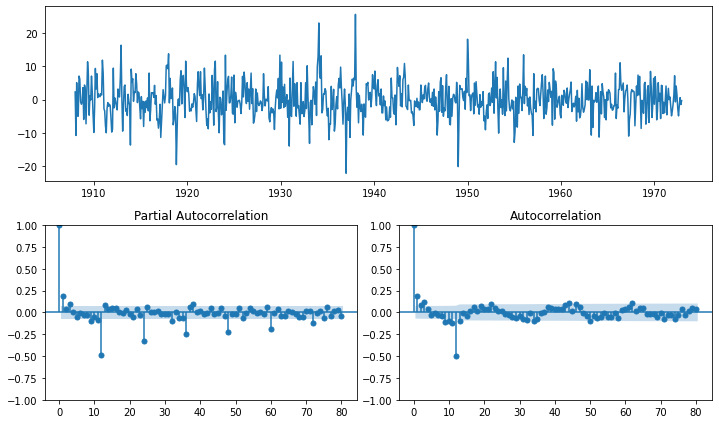

In [21]:
diff_ts = monthly_temp['temp'].diff(periods=12).dropna()

fig = plt.figure(figsize=(10, 6))
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
ax1.plot(diff_ts)
ax2 = plt.subplot2grid((2, 2), (1, 0))
plot_pacf(diff_ts, lags=80, ax=ax2)
ax3 = plt.subplot2grid((2, 2), (1, 1))
plot_acf(diff_ts, lags=80, ax=ax3)
plt.tight_layout();

In [25]:
# fit SARIMA monthly based on helper plots
sar = ss.tsa.statespace.sarimax.SARIMAX(monthly_temp[:750].temp, 
                                order=(2,1,2), 
                                seasonal_order=(0,1,1,12), 
                                trend='c').fit(disp=False)
sar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                 temp   No. Observations:                  750
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 12)   Log Likelihood               -2026.063
Date:                              Wed, 18 Dec 2024   AIC                           4066.127
Time:                                      11:53:39   BIC                           4098.345
Sample:                                  01-01-1907   HQIC                          4078.551
                                       - 06-01-1969                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -6.669e-05      0.000     -0.374      0.709      -0.000       0.000
ar.L1         -0.7659      0.170     -4.493      0.000      -1.100      -0.432
ar.L2          0.1790      0.042      4.260      0.000       0.097       0.261
ma.L1         -0.0543      0.182     -0.298      0.765      -0.411       0.303
ma.L2         -0.9434      0.173     -5.444      0.000      -1.283      -0.604
ma.S.L12      -0.9816      0.039    -24.907      0.000      -1.059      -0.904
sigma2        13.3629      0.955     13.990      0.000      11.491      15.235
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               202.06
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.77   Skew:                            -0.55
Prob(H) (two-sided):                  0.04   Kurtosis:                         5.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

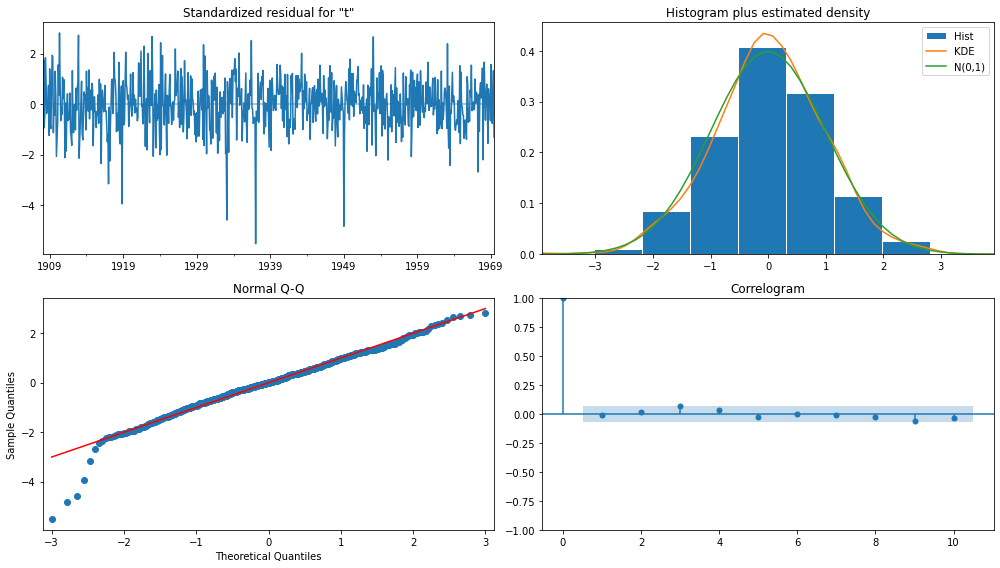

In [26]:
sar.plot_diagnostics(figsize=(14, 8))
plt.tight_layout();

MSE: 9.21


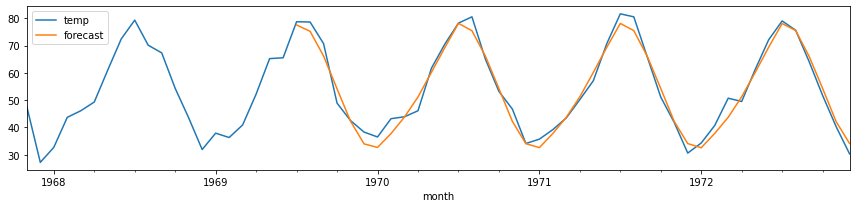

In [27]:
monthly_temp['forecast'] = sar.predict(start = 750, end= 792, dynamic=False)  
monthly_temp[730:][['temp', 'forecast']].plot(figsize=(12, 3))
plt.tight_layout();
print(f"MSE: {mse(monthly_temp['temp'][-42:],monthly_temp['forecast'][-42:]):.2f}")

## AutoARIMA

- At this point it should be clear that identifying the optimal SARIMA model is difficult.
- It requires careful analysis, trial and errors, and some experience.
- The following cheatsheet summarizes some rules of thumb to select the model.

**💡 Cheatsheet: coefficients setting**

<center>
    
|ACF Shape|Indicated Model|
|---|:---|
|Exponential, decaying to zero|AR model. Use the PACF to identify the order of the ARe model.|
|Alternating positive and negative, decaying to zero|AR model. Use the PACF to identify the order.|
|One or more spikes, rest are essentially zero|MA model, order identified by where plot becomes zero.|
|Decay, starting after a few lags|Mixed AR and MA (ARMA) model.|
|All zero or close to zero|Data are essentially random.|
|High values at fixed intervals|Include seasonal AR term.|
|No decay to zero|Series is not stationary.|
    
</center>

- An alternative to manual model selection is to use automated procedures.
- Here enters AutoARIMA.
- AutoARIMA requires you to specify the maximum range of values to try.
- Afterwards, it tries to find the best confgiuration among the possible ones.
- See [here](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html) for a complete list and description of the options available.

In [19]:
# Split the data into train and test sets
train, test = monthly_temp[:750].temp, monthly_temp[750:].temp

# Use auto_arima to find the best ARIMA model
model = pm.auto_arima(train, 
                      start_p=0, start_q=0,
                      test='adf',       # Use adftest to find optimal 'd'
                      max_p=2, max_q=2, # Maximum p and q
                      m=12,             # Seasonality
                      start_P=0, start_Q=0,
                      max_P=2, max_Q=2, # Maximum p and q
                      seasonal=True,    # Seasonal ARIMA
                      d=None,           # Let model determine 'd'
                      D=1,              # Seasonal difference
                      trace=True,       # Print status on the fits
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)    # Stepwise search to find the best model

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=4558.569, Time=0.07 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=4318.918, Time=0.62 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.26 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=4556.588, Time=0.07 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=4531.290, Time=0.23 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=4230.055, Time=3.20 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=5.11 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.18 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=4256.241, Time=2.79 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=4230.500, Time=3.35 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=4228.386, Time=3.99 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=4317.592, Time=1.30 sec
 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=inf, Time=7.83 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=3.46 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=4

In [ ]:
# Summarize the model
print(model.summary())

# Frecast future values
monthly_temp['forecast'] = model.predict(n_periods=len(test)) 
monthly_temp[730:][['temp', 'forecast']].plot(figsize=(12, 3))
plt.tight_layout();
print(f"MSE: {mse(monthly_temp['temp'][-42:],monthly_temp['forecast'][-42:]):.2f}")

### AutoARIMA or not AutoARIMA?

While being very convenient, like all automated procedures `auto_arima` comes with drawbacks.

1. `auto_arima` can be *computationally expensive*, especially for large datasets and when exploring a wide range of models. 

2. Automated model selection lacks the qualitative insights a human might bring to the modeling process.
   - These, include understanding business cycles, external factors, or anomalies in the data. 

3. The defaults in `auto_arima` may not be optimal for all time series data. 
   - The range of values to explore should be adjusted properly each time.
   - This might become almost as tricky as doing manual model selection.

4. `auto_arima` requires a sufficiently long time series to accurately identify patterns and seasonality. 

5. The selection of the best model is typically based on *statistical criteria* such as AIC or BIC.
   - These, might not always align with practical performance metrics such as MSE.

## Grid search

- Selecting the best ARIMA model is as much an art as it is a science, involving iteration and refinement.
- A common approach is to select a set of candidates for $(p,d,q)\times (P,D,Q,s)$ and fit a model for each possible combination.

- For each fit model:
    - Analyze the residuals using the visual techniques and the statistical tests discussed before.
    - Evaluate the prediction performance. 🤔 How?
    - Evaluate its complexity. 🤔 How?

### Prediction performance 

Use MSE and/or MAPE to evaluate the prediction performance of the model.

**Mean Squared Error (MSE)**

- MSE is the average of the squared differences between the observed values and the predictions.
- $MSE = \frac{1}{n}\sum_{i=1}^{n}(Y_i - \hat{Y}_i)^2$, where $Y_i$ is the actual observation and $\hat{Y}_i$ is the forecasted value.
- In SARIMA model selection, a model with a lower MSE is preferred, indicating better fit to the data.

**Mean Absolute Percentage Error (MAPE)**

- MAPE is the average of the absolute percentage errors of forecasts.
- $MAPE = \frac{100\%}{n}\sum_{i=1}^{n}\left|\frac{Y_i - \hat{Y}_i}{Y_i}\right|$, where $Y_i$ is the actual observation and $\hat{Y}_i$ is the forecasted value.
- MAPE expresses errors as a percentage, making it straightforward to understand the magnitude of forecasting errors.
- If you are comparing models that predict different quantities (e.g., dollars vs. units sold), the percentage error allows for a more apples-to-apples comparison.
- Also, when you're more interested in the relative size of the errors than in their absolute size, MAPE is relevant. 
- Finally, MAPE is useful when the magnitude of the data varies significantly.

### Model complexity

Use AIC or BIC to estimate the model's complexity.

**Akaike Information Criterion (AIC)**

- AIC is a measure of the relative quality of statistical models for a given set of data. 
- It deals with the trade-off between the goodness of fit of the model and the complexity of the model.
- $AIC = 2k - 2\ln(\hat{L})$, where $k$ is the number of parameters in the model, and $\hat{L}$ is the maximized value of the likelihood function for the model.
- The model with the **lowest AIC value** is preferred, as it fits the data well but is not overly complex.

**Bayesian Information Criterion (BIC)**

- Similar to AIC, the BIC is another criterion for model selection, but it introduces a stronger penalty for models with more parameters.
- $BIC = \ln(n)k - 2\ln(\hat{L})$, where $n$ is the number of observations, $k$ is the number of parameters, and $\hat{L}$ is the maximized likelihood.
- A **lower BIC value** indicates a better model, preferring simpler models to complex ones, especially as the sample size $n$ increases.

### Restricting the search with Exploratory Data Analysis (EDA)

- Grid search can be very expensive if done exaustively, especially on limited hardware.
- An Exploratory Data Analysis can help to significantly reduce the number of candidates to try out.

#### Selecting the candidates for differentiation

- Let's start by identifying all the candidates for seasonal and general differencing.
- In this case, we already know that the main seasionality is $s=12$. 
- Should we apply first the general or the seasonal differencing?

**💡 Hint**

- If seasonal patterns are dominant and the goal is to remove seasonality before addressing any trend, start with **seasonal differencing**. 
    - This is particularly useful when the seasonal pattern is strong and clear.
- If the trend is the predominant feature, you might start with **standard differencing**.

#### Filter-out non-stationary candidates

- Among all the differenced time series, keep only those that are stationary (according to ADF).

#### Select candidates for $p, q, P, Q$

- We are going to make a script to extract canidates for the orders of the AR and MA component, both in the general and the seasonal part.
- We will leverage the ACF and PACF functions.
- So far, we looked at the `acf_plot` and `pacf_plot`.
- Now we need to use `acf` and `pacf`.
- We need to understand how these relate.

#### Define the grid of values to search

In [305]:
# possible values
p = [1, 2, 3]
d = [0, 1]
q = [1, 2]
P = [0, 1]
D = [0, 1, 2]
Q = [0, 1]
s = [12]

# create all combinations of possible values
pdq = list(product(p, d, q))
PDQm = list(product(P, D, Q, s))

print(f"Number of total combinations: {len(pdq)*len(PDQm)}")

Number of total combinations: 144


#### Train the models

- We defined a function that takes every model configuration and trains a model.
- For each model, we save the MSE, MAPE, AIC and BIC.

In [306]:
warnings.simplefilter("ignore")
def SARIMA_grid(endog, order, seasonal_order):

    # create an empty list to store values
    model_info = []
       
    #fit the model
    for i in tqdm(order):
        for j in seasonal_order:
            try:
                model_fit = SARIMAX(endog=endog, order=i, seasonal_order=j).fit(disp=False)
                predict = model_fit.predict()
            
                # calculate evaluation metrics: MAPE, RMSE, AIC & BIC
                MAPE = (abs((endog-predict)[1:])/(endog[1:])).mean()
                MSE = mse(endog[1:], predict[1:])
                AIC = model_fit.aic
                BIC = model_fit.bic
            
                # save order, seasonal order & evaluation metrics
                model_info.append([i, j, MAPE, MSE, AIC, BIC])
            except:
                continue
                
    # create a dataframe to store info of all models
    columns = ["order", "seasonal_order", "MAPE", "MSE", "AIC", "BIC"]
    model_info = pd.DataFrame(data=model_info, columns=columns)
    return model_info

In [307]:
# create train-test-split
train = monthly_temp['temp'].iloc[:int(len(monthly_temp)*0.9)]
test = monthly_temp['temp'].iloc[int(len(monthly_temp)*0.9):]

In [ ]:
start = time.time()

# fit all combinations into the model
model_info = SARIMA_grid(endog=train, order=pdq, seasonal_order=PDQm)

end = time.time()
print(f'time required: {end - start :.2f}')

  0%|          | 0/12 [00:00<?, ?it/s]

#### Analyze the results

- Show the 10 best models according to the performance (MSE, MAPE) and model complexity (AIC, BIC).

In [ ]:
# 10 least MAPE models
least_MAPE = model_info.nsmallest(10, "MAPE")
least_MAPE

In [ ]:
# 10 least MSE models
least_MSE = model_info.nsmallest(10, "MSE")
least_MSE

In [ ]:
# 10 least AIC models
least_AIC = model_info.nsmallest(10, "AIC")
least_AIC

In [ ]:
# 10 least BIC models
least_BIC = model_info.nsmallest(10, "BIC")
least_BIC 

- We can check if there are overlaps between the 4 different groups using the `set` function.

In [ ]:
set(least_MAPE.index) & set(least_MSE.index)

In [ ]:
set(least_AIC.index) & set(least_BIC.index)

In [ ]:
set(least_MSE.index) & set(least_AIC.index)

- Show the top model according to each metric.

In [ ]:
# the best model by each metric
L1 = model_info[model_info.MAPE == model_info.MAPE.min()]
L2 = model_info[model_info.MSE == model_info.MSE.min()]
L3 = model_info[model_info.AIC == model_info.AIC.min()]
L4 = model_info[model_info.BIC == model_info.BIC.min()]

best_models = pd.concat((L1, L2, L3, L4))
best_models

#### Compute performance on the test set

- Take the best models, compute the predictions and evaluate their performance in terms of MAPE on the w.r.t. test data.

In [ ]:
# Take the configurations of the best models
ord_list = [tuple(best_models.iloc[i,0]) for i in range(best_models.shape[0])]
s_ord_list = [tuple(best_models.iloc[i,1]) for i in range(best_models.shape[0])]
preds, ci_low, ci_up, MAPE_test = [], [], [], []

# Fit the models and compute the forecasts
for i in range(4):
    model_fit = SARIMAX(endog=train, order=ord_list[i], 
                        seasonal_order=s_ord_list[i]).fit(disp=False) # Fit the model
    pred_summary = model_fit.get_prediction(test.index[0], 
                                            test.index[-1]).summary_frame() # Compute preds
    # Store results
    preds.append(pred_summary['mean'])
    ci_low.append(pred_summary['mean_ci_lower'][test.index])
    ci_up.append(pred_summary['mean_ci_upper'][test.index])
    MAPE_test.append((abs((test-pred_summary['mean'])/(test)).mean()))

In [ ]:
# visualize the results of the fitted models
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(24,6),
                        sharex=True, sharey=True)

titles = [f'Least MAPE Model {ord_list[0]} x {s_ord_list[0]}',
          f'Least MSE Model {ord_list[1]} x {s_ord_list[1]}',
          f'Least AIC Model {ord_list[2]} x {s_ord_list[2]}',
          f'Least BIC Model {ord_list[3]} x {s_ord_list[3]}']
k = 0
for i in range(2):
    for j in range(2):
        axs[i,j].plot(monthly_temp['temp'], label='Ground Truth')
        axs[i,j].plot(preds[k], label='Prediction')
        axs[i,j].set_title(titles[k] + f' -- MAPE test: {MAPE_test[k]:.2%}')
        axs[i,j].legend()
        axs[i,j].axvline(test.index[0], color='black', alpha=0.5, linestyle='--')
        axs[i,j].fill_between(x=test.index, y1=ci_low[k], y2=ci_up[k], color='orange', alpha=0.2)
        axs[i,j].set_ylim(bottom=20, top=90)
        axs[i,j].set_xlim(left=monthly_temp.index[-120], right=monthly_temp.index[-1])
        k += 1
plt.tight_layout()
plt.show()

---

## Summary

1. Autoregressive Moving Average (ARMA) models.
2. Autoregressive Integrated Moving Average (ARIMA) models.
3. SARIMA models (ARIMA model for data with seasonality).
4. Selecting the best model.

---

## Exercise

- Look at sensor data that tracks atmospheric CO2 from continuous air samples at Mauna Loa Observatory in Hawaii. This data includes CO2 samples from MAR 1958 to DEC 1980.

In [ ]:
co2 = pd.read_csv('https://zenodo.org/records/10951538/files/arima_co2.csv?download=1', 
                  header = 0,
                  names = ['idx', 'co2'],
                  skipfooter = 2)

# convert the column idx into a datetime object and set it as the index
co2['idx'] = pd.to_datetime(co2['idx'])
co2.set_index('idx', inplace=True)

# Rmove the name "idx" from the index column
co2.index.name = None
co2

- Determine the presence of main trend and seasonality in the data.
- Determine if the data are stationary.
- Split the data in train (90%) and test (10%).
- Find a set of SARIMAX candidate models by looking at the ACF and PACF.
- Perform a grid search on the model candidates.
- Select the best models, based on performance metrics, model complexity, and normality of the residuals.
- Compare the best model you found with the one from autoarima.